In [136]:
using StatsBase
using LinearAlgebra
using Plots
using Random

In [137]:
#Define the parameters n, L(n), t, Ne(L)

n = 7
L = 8*n + 4
t = 1
Ne = Int(L / 2)

30

In [138]:
#Here we define the hamiltonian and the states - Lstate (length L with +1 -1 0 and 2 as occupancies)
#as well as the conversion between states from L to the extended one of 2L and viceversa

function Hamiltonian(L,t)
    H = zeros(2*L, 2*L)
    H[1,L] = -t
    H[L,1] = -t
    H[2L,L+1] = -t
    H[L+1,2L] = -t
    for i=1:2*L
      for j=1:2*L
        if i == j + 1 || i == j - 1
          H[i,j] = -t
        end 
      end
    end
    H[L,L+1]=0
    H[L+1,L]=0
    return H
end

H = Hamiltonian(L,t);


#generate, convert state
function Lstate(L)                                 #generate a state of length L
    Lstated, Lstateu, Lstate = zeros(L), zeros(L), zeros(L)
    randomposu = sample(collect(1:L), Int(L/4), replace=false)
    randomposd = sample(collect(1:L), Int(L/4), replace=false)
    for j in randomposu
        Lstateu[j] = 1
    end
    for j in randomposd
        Lstated[j] = -1
    end
    for i=1:L 
        if Lstated[i] == -1 && Lstateu[i] == 1
            Lstate[i] = 2
        else
            Lstate[i] = Lstated[i] + Lstateu[i]
        end
    end
    return Lstate
end


function extendedstate(Lstatevector)               #take a state of length L and make it 2*L
    L = length(Lstatevector)
    State2L = zeros(2*L)
    for j=1:L
        if Lstatevector[j] == -1
            State2L[j + L] = 1
        elseif Lstatevector[j] == 1
            State2L[j] = 1
        elseif Lstatevector[j] == 2
            State2L[j], State2L[j + L] = 1,1
        else
            State2L[j] = 0
        end
    end
    return State2L
end


function shortstate(ext_state)                    #pass trom 2*L state to L state
    L = Int(length(ext_state)/2)
    sh_state = zeros(L)
    for j=1:L
        if ext_state[j]==1
            sh_state[j]=1
        end
    end
    for j=1:L
        if ext_state[L+j]==1
            if sh_state[j]==1
                sh_state[j]=2
            else
                sh_state[j]=-1
            end
        end
    end
    return sh_state
end

shortstate (generic function with 1 method)

In [139]:
#In this section we define functions to found the occupied and empty sites in our state and the move - hopping functions
#There are 3 options for the move, move_L and hopping makes a hop in vectors of length L and move_last_2L with ones  

#generate a move
function Pauli(x,i,j)                 #check if state i and j are both occupied
    if x[i] == 1 && x[j] == 1
        return true
    end
    return false
end 

function occupied_states(v)         #generate a vector with positions of occupied states (from 2*L states)
    occ_states = []
    L = length(v)
    for i = 1:L
        if v[i] == 1
            append!(occ_states, i)
        end
    end
    return occ_states
end


function occupied_states_L(v)
    occ_states = []
    L =length(v)
    for i = 1 : L
        if abs(v[i]) == 1
            append!(occ_states, i )
            
        elseif v[i] == 2
            append!(occ_states, i )
        
        end
    end
    return occ_states
end

function empty_states(v)
    empty_st_u = []
    empty_st_d = []
    L = length(v)
    for i = 1 : Int(L/2)
        if v[i] == 0
               append!(empty_st_u, i )
        end
    end
    for i = Int(L/2)+1 : L
        if v[i] == 0
               append!(empty_st_d, i )
        end
    end
    return empty_st_u, empty_st_d
end

function move_L(w)
    
   v = copy(w)
   i = rand(occupied_states_L(v))
   j = rand(-1:2:1)

    j_pbc = mod(i+j,L)
    j_pbc == 0 ? j_pbc = L : j_pbc = j_pbc

    if v[i] != v[j_pbc] && v[j_pbc]!=2

        if abs(v[i])==1
            v[j_pbc] == 0 ? v[j_pbc] = v[i] : v[j_pbc] = 2
            v[i] = 0

        elseif v[i]==2    
            spin = rand(-1:2:1)

        if v[j_pbc] != spin
           v[i] = -spin

        if abs(v[j_pbc]) == 1 
            v[j_pbc] = 2 
        elseif v[j_pbc] == 0 
            v[j_pbc] = spin 
        end

        end    
        end
            
    end

    return v
    
end

function move_last_2L(w)
    v = copy(w)
    L = length(v)
    i = rand(occupied_states(v))
    if i < L+1 
        j = rand(empty_states(v)[1])
        v[j] = v[i]
    else 
        j = rand(empty_states(v)[2])
    end
    v[i] = 0
    b = shortstate(v)
    return b
end

function hopping(v)
    w = copy(v)
    occupied_positions = occupied_states_L(v)
    i = rand(occupied_positions)
    nn = [v[i + 1],v[i - 1]]
    nnpos = [i + 1, i - 1]
    rndnnpos = rand([i + 1,i - 1])
    rndnn = rand(nn)
    
    if nn[1] == 2 && nn[2] == 2 || v[i] == 1 && nn[1] == 1 && nn[2] == 2 || v[i] == 1 && nn[1] == 2 && nn[2] == 1 || v[i] == 1 && nn[1] == 1 && nn[2] == 1 || v[i] == -1 && nn[1] == -1 && nn[2] == 2 || v[i] == -1 && nn[1] == 2 && nn[2] == -1 || v[i] == -1 && nn[1] == -1 && nn[2] == -1
        i = rand(deleteat!(occupied_positions, findall(x->x==i,occupied_positions)))
    end
    
    if v[i] == 1 && v[rndnnpos] == 1 || v[i] == 1 && v[rndnnpos] == 2
        rndnnpos = rand(deleteat!(nnpos, findall(x->x==rndnnpos, nnpos)))
    end
    
    if v[i] == -1 && v[rndnnpos] == -1 || v[i] == -1 && v[rndnnpos] == 2
        rndnnpos = rand(deleteat!(nnpos, findall(x->x==rndnnpos, nnpos)))
    end
    
    if v[i] == 2 && v[rndnnpos] == 2
        rndnnpos = rand(deleteat!(nnpos, findall(x->x==rndnnpos, nnpos)))
    end
     
    if v[i] == 1
        if v[rndnnpos] == -1
            w[i], w[rndnnpos] = 0, 2
        elseif v[rndnnpos] == 0
            w[i], w[rndnnpos] = 0, 1
        end
    
    elseif v[i] == -1 
        if v[rndnnpos] == 1
            w[i], w[rndnnpos] = 0, 2
        elseif v[rndnnpos] == 0
            w[i], w[rndnnpos] = 0, -1
        end
    
    elseif v[i] == 2
        if v[rndnnpos] == 1 
            w[i], w[rndnnpos] = 1, 2
        elseif v[rndnnpos] == -1
            w[i], w[rndnnpos] = -1,2
        elseif v[rndnnpos] == 0
            choosenspin = rand([1,-1])
            w[i], w[rndnnpos] = -1*choosenspin, choosenspin
        end
    end
    
    return w
end

hopping (generic function with 1 method)

In [140]:
#generate unitary matrices and the ratio of determinants

U = eigvecs(H)  #unitary matrix
Udag = inv(U)   #U^-1
E = eigvals(H)  #eigenvalues of H

function U1(A, Ne) #take the first Ne columns
    U_1 = A[:,1:Ne]
    return U_1
end

U_1 = U1(U,Ne)

function U_tilde(A,v)                  #takes just the rows related to occupied states, Ne*Ne matrix
    U_tild = []
    U_tild = A[occupied_states(v),:]
    return U_tild
end

function ratio_det(v, z)
    rat= det(U_tilde(U_1,z))/det(U_tilde(U_1,v))
    return rat
end  


ratio_det (generic function with 1 method)

In [141]:
#Jastrow factor
function n_i(vi)           #counts the number of els in positions vi, returning (# up , # down)
    
    n_up = 0
    n_down = 0
    
        if vi == 1
            n_up += 1
            
        elseif vi == -1
            n_down += 1
                
        elseif vi == 2
            n_down += 1
            n_up += 1
                
        end

return n_up, n_down

end

function Jastrow(state,g,v)
            
    D=length(state)       
    
    Spins=0
    Occupancies=0  
    
   # n1 = n_i(state[D])[1] + n_i(state[D])[2]
    n2 = 0
    
    for i = 1 : D     
            
    j_pbc = mod(L+i+1,L)
    j_pbc == 0 ? j_pbc = L : j_pbc = j_pbc
                
        n_up= n_i(state[i])[1]    
        n_down = n_i(state[i])[2]
                
    Spins = Spins + n_up*n_down 
                
    n1= n_up + n_down
        
    n_up= n_i(state[j_pbc])[1]    
    n_down = n_i(state[j_pbc])[2]
    
     n2= n_up + n_down
        
    n1n2 = n1*n2   
    n1 = n2
                
    Occupancies = Occupancies + n1n2
            
        end
    
    arg=  -g*Spins -v*Occupancies
            
return exp(arg)

end
#This function calculates the density observable in the odd sites A
function nA(v)
    nA = 0
    for j=1:length(v)
        if j%2 != 0
            nA += sum(n_i(v[j])) 
        end
    end
    return nA*2/length(v)
end

#This function calculates the density observable in the even sites B
function nB(v)
    nB = 0
    for j=1:length(v)
        if j%2 == 0
            nB += sum(n_i(v[j])) 
        end
    end
    return nB*2/length(v)
end

nB (generic function with 1 method)

In [142]:
#Block analysis
function Block(v, Ne, Ni)
    
    Average_Bin = []
    
    N=length(v)
    
    Lbin = Ne
    
    Nbin = floor(Int,N/Lbin)
    
    a=0
    b=0
    
    for i in Ni:Nbin
       
    a = (i-1)*Lbin +1
    b = i*Lbin
        
av_bin = (1/Int(abs(Lbin)))*(sum(v[Int64(a):Int64(b)]))
        
push!(Average_Bin,av_bin)
        
    end

return Average_Bin, sum(Average_Bin)/(Nbin-Ni+1), Nbin

end

Block (generic function with 1 method)

In [143]:
#Block analysis
function Block(v, Ne, Ni)
    
    Average_Bin = []
    
    N=length(v)
    
    Lbin = Ne
    
    Nbin = floor(Int,N/Lbin)
    
    a=0
    b=0
    
    for i in Ni:Nbin
       
    a = (i-1)*Lbin +1
    b = i*Lbin
        
av_bin = (1/Int(abs(Lbin)))*(sum(v[Int64(a):Int64(b)]))
        
push!(Average_Bin,av_bin)
        
    end

return Average_Bin, sum(Average_Bin)/(Nbin-Ni+1), Nbin

end

Block (generic function with 1 method)

In [144]:
f = Figure()
Axis(f[1, 1])

x = collect(1:10)
y = [MC_pietro(a,10,v,30,5,100)[1] for v in x]

lowerrors = [-MC_pietro(a,10,v,30,5,100)[2] for v in x]
higherrors = [MC_pietro(a,10,v,30,5,100)[2] for v in x]

errorbars!(x, y, higherrors, color = :red) 

errorbars!(x, y, lowerrors, color = :red) # same low and high error
# plot position scatters so low and high errors can be discriminated
scatter!(x, y, markersize = 3, color = :black)

f


LoadError: [91mUndefVarError: Figure not defined[39m

In [145]:
function Error_Block(v, Ne, Ni)
    
    SD_Array = []

    Average_Bin, ave, Nbin = Block(v, Ne, Ni)
    
    for i in 1:length(Average_Bin)

    av_bin = Average_Bin[i] - ave
        
     push!(SD_Array,av_bin^2 )
        
    end

return sqrt(mean(SD_Array))/sqrt(Nbin)
    
end

Error_Block (generic function with 1 method)

In [146]:
function orthogonal(w, i)
    v = copy(w)
    L = length(v)
    states = []
    J = [-1,1]
    
    for j in J
        
        v = copy(w)
    
        j_pbc = mod(i+j,L)
        j_pbc == 0 ? j_pbc = L : j_pbc = j_pbc

            if v[i] != v[j_pbc] && v[j_pbc]!=2

                if abs(v[i])==1
                v[j_pbc] == 0 ? v[j_pbc] = v[i] : v[j_pbc] = 2 
                v[i] = 0    
                push!(states,v)

                elseif v[i]==2    
                Spin = [-1,1]

                    for spin in Spin
                    v = copy(w)

                            if spin != v[j_pbc] && v[j_pbc]!=2
                                v[j_pbc] == 0 ? v[j_pbc] = spin : v[j_pbc] = 2 
                                v[i] = -spin
                                push!(states,v)
                            end  
                      end
                 end   
          end
        
    end 
    
    return states
    
end

orthogonal (generic function with 1 method)

In [148]:

function MC_pietro(q0, g, v, U,V, nsteps = 1000)
    
    t=1
    #Random.seed!(1234)
    local_est = 0
    state_L = copy(q0)
    local_est_array = []
    locals = []
    
    state_new_L = 0
    state_new_2L = 0
    
    x_prime_L = []
    x_prime_2L = []
    sumA=0
    sumB=0
    accepted_moves = 0
    state_new_L = zeros()
    x_L = zeros()
    x_2L = zeros()
    
    Suma_A = []
    Suma_B = []
    
    Pot= []
    
    EN = []
    
    k=0
    l=0
    
   
    for istep = 1:nsteps

        for j = 1:Ne
            state_2L = extendedstate(state_L)
            state_new_L = move_L(state_L)
            state_new_2L = extendedstate(state_new_L)

            acc =  (ratio_det(state_2L,state_new_2L) * (Jastrow(state_new_L,g,v)/Jastrow(state_L,g,v)))^2
            
            acc = min(1,acc)

            if acc>rand()        #metropolis rule
                state_L = copy(state_new_L)
                state_2L = copy(state_new_2L)
                accepted_moves += 1
            end
        end
        x_L = copy(state_new_L)
        x_2L = copy(state_new_2L)
        pot = log(Jastrow(x_L,-U,-V))
        #display(pot)
        
              e_n = 0
        
                 for i in occupied_states_L(x_L)
        
                 o_states = orthogonal(x_L, i)
            
                     for j in 1:length(o_states)
                        x_prime_L = o_states[j]
                        x_prime_2L = extendedstate(x_prime_L)   
                         Prob =  (ratio_det(x_2L,x_prime_2L)*((Jastrow(x_prime_L,g,v)/Jastrow(x_L,g,v))))^2
                         acc = min(1,Prob)

                           if Prob<=1 && Prob>rand()   
                           local_est = -t*ratio_det(x_2L,x_prime_2L)*(Jastrow(x_prime_L,g,v)/Jastrow(x_L,g,v))
      
                           end
                
                             e_n += local_est
                                              
                     end      
                 end
   
           push!(EN,e_n)
        
           e_n += pot 
        
           push!(locals,e_n)
            
           push!(Pot,pot)
        
          end
    
    return  Block(locals,floor(Int,Ne/2),1)[2]
end

MC_pietro (generic function with 2 methods)

In [153]:
#=
#Monte Carlo simulation that calculates nA along the simulation
import Random

function MC_pietro(q0, g, v, U,V, nsteps = 1000)
    #Random.seed!(1234)
    local_est = 0
    state_L = copy(q0)
    local_est_array = []
    locals = []
    x_prime_L = []
    x_prime_2L = []
    sumA=0
    sumB=0
    accepted_moves = 0
    state_new_L = zeros()
    x_L = zeros()
    x_2L = zeros()
    
    Suma_A = []
    Suma_B = []
    
    for istep = 1:nsteps
        
        for j = 1:Ne
            state_2L = extendedstate(state_L)
            state_new_L = move_L(state_L)
            state_new_2L = extendedstate(state_new_L)
            acc =  (ratio_det(state_2L,state_new_2L) * (Jastrow(state_new_L,g,v)/Jastrow(state_L,g,v)))^2       #acceptance 
            display((Jastrow(state_new_L,g,v)/Jastrow(state_L,g,v)))
            acc = min(1,acc)

            if acc>rand()        #metropolis rule
                x_L = copy(state_new_L)
                #display(x_L)
                x_2L = copy(state_new_2L)
                accepted_moves += 1
            end
        end
        
        #compute observables
        e_n = 0
        pot = log(Jastrow(x_L,-U,-V))            #x = x'
             #display(pot)
            
             for i in occupied_states_L(x_L)        # x' hopping neighbour of x
                 o_states = orthogonal(x_L, i)

                 for j in 1:length(o_states)
                        x_prime_L = copy(o_states[j])
                        x_prime_2L = extendedstate(x_prime_L)        

                        local_est = -t*ratio_det(x_2L,x_prime_2L)*(Jastrow(x_prime_L,g,v)/Jastrow(x_L,g,v))
                        #display(local_est)
                        e_n += local_est
                 end
                    
            end
            
            #display(e_n)
        e_n += pot
            
        push!(locals,e_n)
    end
    return mean(locals)
end 

a = Lstate(L);
#MC_prova= MC_pietro(a,10,5,30,5,100)
=#
#Monte Carlo simulation that calculates nA along the simulation
#Monte Carlo simulation that calculates nA along the simulation
import Random

function MC_pietro(q0, g, v, U,V, nsteps = 1000)
    
    t=1
    #Random.seed!(1234)
    local_est = 0
    state_L = copy(q0)
    local_est_array = []
    locals = []
    
    state_new_L = 0
    state_new_2L = 0
    
    x_prime_L = []
    x_prime_2L = []
    sumA=0
    sumB=0
    accepted_moves = 0
    state_new_L = zeros()
    x_L = zeros()
    x_2L = zeros()
    
    Suma_A = []
    Suma_B = []
    
    Pot= []
    
    EN = []
    
    k=0
    l=0
    
    for istep = 1:nsteps

        for j = 1:Ne
            state_2L = extendedstate(state_L)
            state_new_L = move_L(state_L)
            state_new_2L = extendedstate(state_new_L)

            acc =  (ratio_det(state_2L,state_new_2L) * (Jastrow(state_new_L,g,v)/Jastrow(state_L,g,v)))^2
            
            acc = min(1,acc)

            if acc>rand()        #metropolis rule
                state_L = copy(state_new_L)
                state_2L = copy(state_new_2L)
                accepted_moves += 1
            end
        end
          
        x_L = copy(state_new_L)
        x_2L = copy(state_new_2L)
        pot = log(Jastrow(x_L,-U,-V))
        #display(pot)
        
        e_n = 0
        
              for i in occupied_states_L(x_L)
        
                 o_states = orthogonal(x_L, i)
            
                     for j in 1:length(o_states)
                        x_prime_L = o_states[j]
                        x_prime_2L = extendedstate(x_prime_L)   
                        Prob =  (ratio_det(x_2L,x_prime_2L)*((Jastrow(x_prime_L,g,v)/Jastrow(x_L,g,v))))^2
                        acc = min(1,Prob)

                           if Prob<=1 && Prob>rand()   
                    
                         
                           local_est = -t*ratio_det(x_2L,x_prime_2L)*(Jastrow(x_prime_L,g,v)/Jastrow(x_L,g,v))

                           #local_est = -t*ratio_det(x_2L,x_prime_2L)
                           e_n += local_est
                           end 
                           
                     end      
                 end
   
           push!(EN,e_n)
        
           e_n += pot 
        
           push!(locals,e_n)
            
           push!(Pot,pot)
          end
    
    return  Block(locals,Int64(Ne/2),Int64(1))[2] , Error_Block(locals,Int64(Ne/2),Int64(1))
end

MC_pietro (generic function with 2 methods)

In [154]:
a = Lstate(L);
MC_pietro(a,10,2,30,5,100)

27.687762478023803

In [186]:
ENV["GKS_ENCODING"]="utf-8"
using Plots
gr()

Plots.GRBackend()

In [200]:
using Plots
x = collect(0:1:12)
y = [MC_pietro(a,10,v,30,5,100) for v in x]


13-element Array{Float64,1}:
  56.58723843922976
  40.33844747671554
  25.00552231832189
  21.064117141750263
  24.14444335051397
  22.320555506703883
  25.631923300567546
  19.498171892012383
  55.725225809119586
  56.75904176312739
  54.61795284668003
  99.88642863787318
 201.26784115905343

In [203]:
x = collect(0:1:12)
y2 = [MC_pietro(a,10,v,30,15,100) for v in x]

13-element Array{Float64,1}:
 182.76257210625843
 126.88931397278458
  81.08020324221367
  39.41104653449141
  45.84476840616904
  51.81442630683194
  68.72254273066089
  40.34148893231039
  62.5247015125528
  56.62014427758695
  60.92221681081162
 127.75713643101561
 179.86007237205902

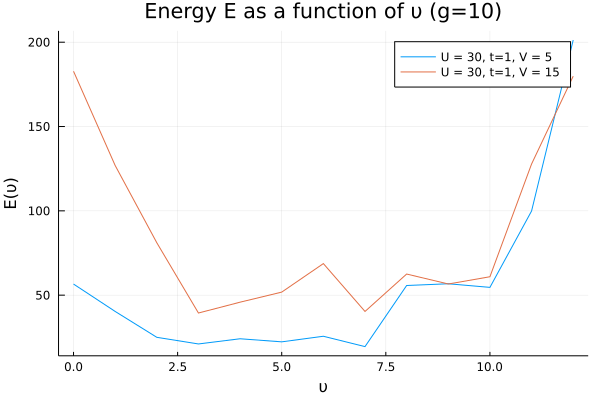

In [211]:
p_6 = plot(x,y, title = "Energy E as a function of υ (g=10)", label = "U = 30, t=1, V = 5")
      plot!(x,y2, title = "Energy E as a function of υ (g=10)", label = "U = 30, t=1, V = 15")
        xlabel!(p_6, "υ")
        ylabel!(p_6, "E(υ)")
#savefig("Q2-1.png")
       

In [175]:

f = Figure()
Axis(f[1, 1])
Label(f[1, 1, Top()], "average electron density", padding = (0, 0, 10, 0))
x = [2,3,4,5,6,7,8]

lowerrors_a = -std_a 
higherrors_a = std_a
lowerrors_b = -std_b 
higherrors_b = std_b

plot!(x, averages_a[1:7], markersize = 15px,color = :blue, label = "n_a")
errorbars!(x, averages_a[1:7], higherrors_a[1:7], color = :blue, label = "n_a") 
errorbars!(x, averages_a[1:7], lowerrors_a[1:7], color = :blue) # same low and high error
# plot position scatters so low and high errors can be discriminated
plot!(x, averages_b[1:6],seriestype = :scatter, color = :red, label = "n_b")
errorbars!(x, averages_b[1:7], higherrors_b[1:7], color = :red) 
errorbars!(x, averages_b[1:7], lowerrors_b[1:7], color = :red)

f

LoadError: LoadError: [91mUndefVarError: @L_str not defined[39m
in expression starting at In[175]:2

In [177]:
using Plots
x = collect(1:1:10)
y = [MC_pietro(a,10,v,30,5,100) for v in x]




LoadError: [91mInterruptException:[39m

In [179]:
p_1 = plot(x,y, title = "electron density, v = 6", label = "n_a")
        plot!(p_1, MC_prova_6[2],label = "n_b")
        xlabel!(p_1, "MC steps")
        ylabel!(p_1, "n")
savefig("plot6.png")


LoadError: [91mUndefVarError: MC_prova_6 not defined[39m

In [151]:
using Plots
x = collect(0:0.1:1)
y = [MC_pietro(a,10,1,2,v,100) for v in x]

plot(x,y)

LoadError: [91mInterruptException:[39m

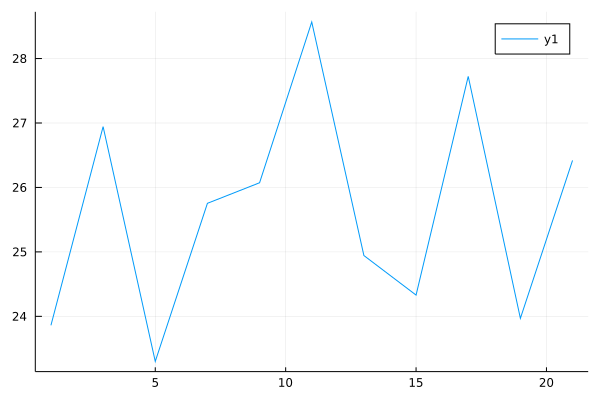

In [127]:
using Plots
x = collect(1:2:21)
y = [MC_pietro(a,10,2,v,5,100) for v in x]

plot(x,y)

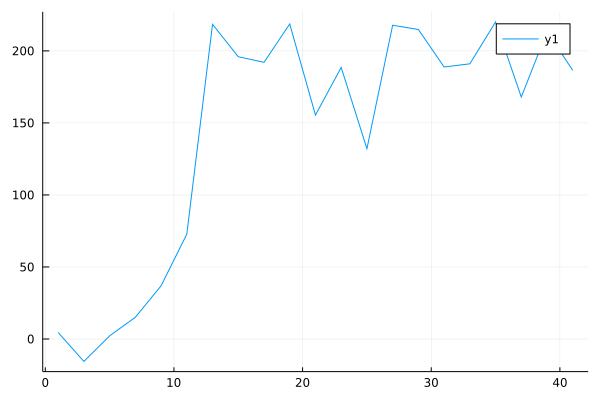

In [107]:
using Plots
x = collect(1:2:41)
y = [MC_pietro(a,10,v,30,5,100) for v in x]

plot(x,y)

In [275]:
import Random
using Statistics


function MC_pietro(q0, g, v, nsteps = 1000)
    #Random.seed!(1234)
    state_L = q0
    sumA=0
    sumB=0
    accepted_moves = 0
    
    Suma_A = []
    Suma_B = []
    
    state_new_L = zeros(length(state_L))
    
    for istep = 1:nsteps
        for j = 1:Ne
            state_2L = extendedstate(state_L)
            state_new_L = move_L(state_L)
            state_new_2L = extendedstate(state_new_L)
            acc =  (ratio_det(state_2L,state_new_2L) * (Jastrow(state_new_L,g,v)/Jastrow(state_L,g,v)))^2       #acceptance 

            acc = min(1,acc)

            if acc>rand()        #metropolis rule
                #print(acc,"\n")
                accepted_moves += 1
                state_L = copy(state_new_L)
            end
        end
            n_newA= nA(state_new_L)
            sumA+=n_newA
            push!(Suma_A,n_newA)
                #push!(Suma_A,n_newA)

            n_newB= nB(state_new_L)
            sumB+=n_newB
            push!(Suma_B,n_newB)
                #push!(Suma_B,n_newB)
    end
    return mean(Suma_A), mean(Suma_B), std(Suma_A), std(Suma_B) 
end 

MC_pietro (generic function with 4 methods)

In [225]:

MC_pietro(a, 10, 2, 1000)

(0.5403858948769118, 0.4596141051230881, 0.1468754033888848, 0.1468754033888848)

In [280]:
x = collect(2:8)
y = [MC_pietro(a, 10, v, 1000) for v in x]

7-element Array{NTuple{4,Float64},1}:
 (0.44403333333333306, 0.5559666666666672, 0.17825249119516942, 0.17825249119516956)
 (0.6149999999999987, 0.38500000000000206, 0.2143539462686602, 0.21435394626865992)
 (0.2090999999999994, 0.7909000000000066, 0.15701613384780205, 0.15701613384780086)
 (0.04996666666666633, 0.9500333333333405, 0.08576854914127488, 0.08576854914127617)
 (0.8209333333333413, 0.17906666666666596, 0.18095759812449166, 0.18095759812449286)
 (0.6222999999999984, 0.37770000000000814, 0.24365930648225428, 0.24365930648225534)
 (0.1590666666666651, 0.8409333333333371, 0.23937786862241303, 0.2393778686224143)

In [281]:
averages_a = []
averages_b = []
std_a = []
std_b = []

for i in 1:length(x)
    push!(averages_a, y[i][1])
    push!(averages_b, y[i][2])
    push!(std_a, y[i][3])
    push!(std_b, y[i][4])
    
end

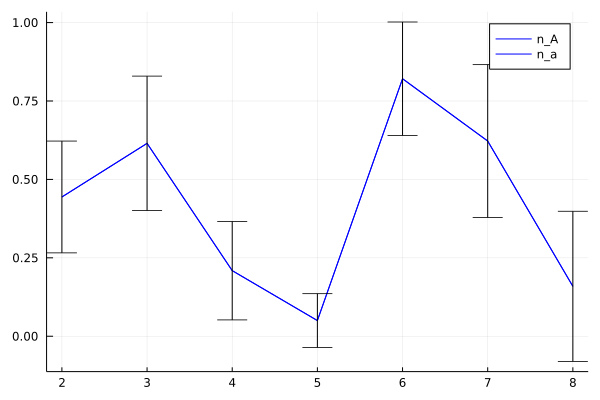

In [282]:


f = plot(x, averages_a, markersize = 15,color = :blue, label = "n_A")

lowerrors_a = -std_a 
higherrors_a = std_a
lowerrors_b = -std_b 
higherrors_b = std_b

plot!(x, averages_a, markersize = 15,color = :blue, label = "n_a", yerror=higherrors_a)


f
#savefig(f,"av_el.png")


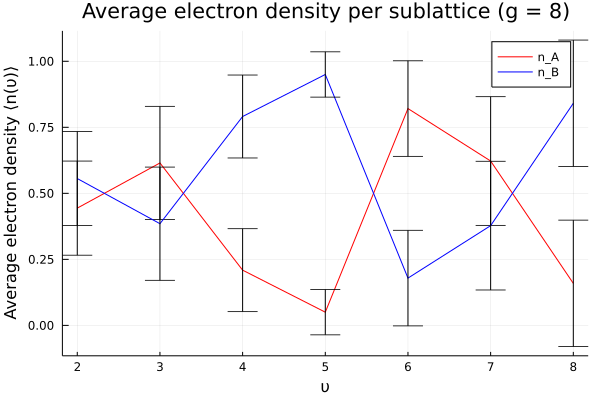

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:7.
└ @ Plots /Users/dianal.monroy/.julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:7.
└ @ Plots /Users/dianal.monroy/.julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:7.
└ @ Plots /Users/dianal.monroy/.julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:7.
└ @ Plots /Users/dianal.monroy/.julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 2:21.
└ @ Plots /Users/dianal.monroy/.julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Info: Data contains NaNs or missing values, and indices of `seriescolor` vector do not match data indices.
│ If you intend elements of `seriescolor` to appl

In [290]:
p_6 = plot(x, averages_a, markersize = 15, color = [:red], label = "n_A", title = "Average electron density per sublattice (g = 8)", yerror = higherrors_a)
      plot!(x, averages_b, markersize = 15, color = [:blue], label = "n_B", title = "Average electron density per sublattice (g = 8)", yerror= higherrors_b)
        xlabel!(p_6, "υ")
        ylabel!(p_6, "Average electron density ⟨n(υ)⟩")
#savefig("Q2-1.png")